In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from nltk import word_tokenize
import random

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = load_dataset('ag_news')

train_dataset_hf = dataset['train'] 
test_dataset_hf = dataset['test']    

train_df = pd.DataFrame(train_dataset_hf)
test_df = pd.DataFrame(test_dataset_hf)

print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

Using device: cuda
Training Data Shape: (120000, 2)
Testing Data Shape: (7600, 2)


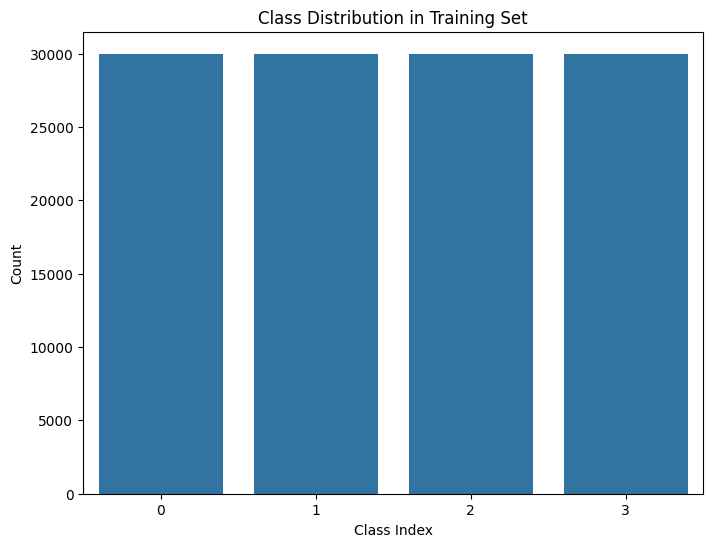


Sample Texts from Each Class:
Class 0 Sample Text:
Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.

Class 1 Sample Text:
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminaries.

Class 2 Sample Text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Class 3 Sample Text:
'Madden,' 'ESPN' Football Score in Different Ways (Reu

In [3]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.show()

print("\nSample Texts from Each Class:")
for class_index in sorted(train_df['label'].unique()):
    sample_text = train_df[train_df['label'] == class_index]['text'].values[0]
    print(f"Class {class_index} Sample Text:\n{sample_text}\n")

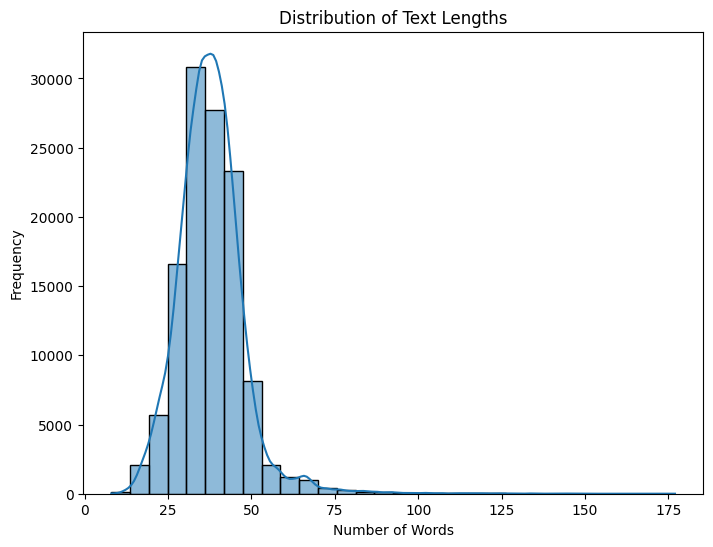

In [4]:
train_df['Text Length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(train_df['Text Length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

def preprocess_text(text):
    return text.lower().strip()

train_df["text"] = train_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            synonym = lem.name().replace('_', ' ').lower()
            if synonym != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

from nltk.tokenize import regexp_tokenize

def synonym_replacement(text, n=1):
    words = regexp_tokenize(text, pattern='\w+')
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def augment_text(text):
    augmented_text = synonym_replacement(text, n=2)
    return augmented_text

augmented_texts = []
augmented_labels = []

for index, row in train_df.iterrows():
    augmented_text = augment_text(row['text'])
    augmented_texts.append(augmented_text)
    augmented_labels.append(row['label'])

augmented_df = pd.DataFrame({
    'label': augmented_labels,
    'text': augmented_texts
})

train_df_augmented = pd.concat([train_df, augmented_df], ignore_index=True)
print("Augmented Training Data Shape:", train_df_augmented.shape)


In [6]:
MODEL_NAME = "google/bert_uncased_L-2_H-128_A-2"  
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_df_augmented['label'] = train_df_augmented['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df_augmented["text"].tolist(),
    train_df_augmented["label"].values,
    test_size=0.1,
    random_state=seed
)

class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = AGNewsDataset(train_texts, train_labels, tokenizer)
val_dataset = AGNewsDataset(val_texts, val_labels, tokenizer)
test_dataset = AGNewsDataset(test_df["text"].tolist(), test_df["label"].values, tokenizer)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
model.to(device)

if hasattr(model, 'classifier'):  
    nn.init.xavier_uniform_(model.classifier.weight)
    if model.classifier.bias is not None:
        nn.init.zeros_(model.classifier.bias)
elif hasattr(model, 'bert'):
    nn.init.xavier_uniform_(model.bert.pooler.dense.weight)
    if model.bert.pooler.dense.bias is not None:
        nn.init.zeros_(model.bert.pooler.dense.bias)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

epochs = 5
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def augment_batch(batch):
    augmented_texts = []
    input_ids = batch['input_ids'].detach().cpu().numpy()
    for ids in input_ids:
        text = tokenizer.decode(ids, skip_special_tokens=True)
        augmented_text = augment_text(text)
        augmented_texts.append(augmented_text)
    encoding = tokenizer(
        augmented_texts,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    encoding = {k: v.to(device) for k, v in encoding.items()}
    return encoding

def train_refixmatch(model, train_loader, unlabeled_loader, val_loader, criterion, optimizer, scheduler, epochs=5, threshold=0.95, lambda_u=1.0):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_unsup_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        
        for batch in unlabeled_loader:
            model.train()
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            outputs = model(**inputs)
            logits = outputs.logits.detach()
            probs = torch.softmax(logits, dim=-1)
            max_probs, pseudo_labels = torch.max(probs, dim=-1)
            mask = max_probs > threshold
            
            if mask.sum() > 0:
                augmented_inputs = augment_batch(batch)
                augmented_outputs = model(**augmented_inputs)
                unsupervised_loss = criterion(augmented_outputs.logits[mask], pseudo_labels[mask])
                unsupervised_loss = lambda_u * unsupervised_loss
                unsupervised_loss.backward()
                optimizer.step()
                scheduler.step()
                total_unsup_loss += unsupervised_loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        avg_unsup_loss = total_unsup_loss / len(unlabeled_loader) if len(unlabeled_loader) > 0 else 0
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
                labels = batch["labels"].to(device)
                outputs = model(**inputs)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Unsupervised Loss: {avg_unsup_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'tokenizer': tokenizer
            }, 'AG_ReFix.pt')

    
    return train_losses, val_losses


Epoch 1/5, Train Loss: 0.4721, Unsupervised Loss: 0.0243, Val Loss: 0.2779
Epoch 2/5, Train Loss: 0.2109, Unsupervised Loss: 0.0247, Val Loss: 0.2154
Epoch 3/5, Train Loss: 0.1635, Unsupervised Loss: 0.0244, Val Loss: 0.1863
Epoch 4/5, Train Loss: 0.1351, Unsupervised Loss: 0.0254, Val Loss: 0.1673
Epoch 5/5, Train Loss: 0.1182, Unsupervised Loss: 0.0257, Val Loss: 0.1504


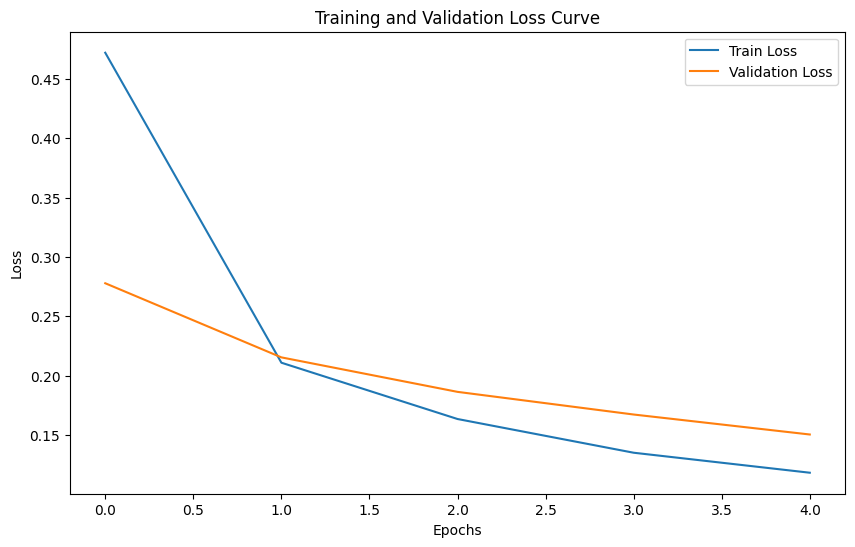

In [8]:
unlabeled_texts = test_df["text"].tolist()

unlabeled_labels = [-1] * len(unlabeled_texts)
unlabeled_dataset = AGNewsDataset(unlabeled_texts, unlabeled_labels, tokenizer)

unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

lambda_u = 1.0 
threshold = 0.95

train_losses, val_losses = train_refixmatch(
    model, train_loader, unlabeled_loader, val_loader,
    criterion, optimizer, scheduler, epochs, threshold, lambda_u
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('AG_ReFix.pt')['model_state_dict'])

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].cpu().numpy()
            outputs = model(**inputs).logits.cpu()
            predictions = outputs.argmax(dim=1).numpy()
            probabilities = torch.nn.functional.softmax(outputs, dim=1).numpy()
            y_true.extend(labels)
            y_pred.extend(predictions)
            y_probs.extend(probabilities)
    
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return acc, precision, recall, f1

evaluate_model(model, test_loader)